In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
class ProteinTokenizer:
    def __init__(self):
        self.amino_acids = [
            'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I',
            'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'
        ]
        self.vocab = {aa: idx for idx, aa in enumerate(self.amino_acids)}
        self.vocab['PAD'] = len(self.vocab)
        self.vocab['UNK'] = len(self.vocab)
        self.pad_token_id = self.vocab['PAD']
        self.unk_token_id = self.vocab['UNK']
        self.id_to_token = {idx: token for token, idx in self.vocab.items()}

    def encode(self, seq):
        return [self.vocab.get(aa, self.unk_token_id) for aa in seq]

    def pad(self, ids, max_len):
        return ids[:max_len] + [self.pad_token_id] * (max_len - len(ids[:max_len]))


In [3]:
class ProteinDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512, is_test=False):
        self.tokenizer = tokenizer
        self.seqs = df['SEQUENCE'].values
        self.seq_ids = df['SEQUENCE_ID'].values
        self.max_len = max_len
        self.is_test = is_test
        self.labels = None

        if not is_test:
            self.labels = df['LABEL'].astype('category').cat.codes.values
            self.label_map = dict(enumerate(df['LABEL'].astype('category').cat.categories))

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        tokens = self.tokenizer.encode(self.seqs[idx])
        padded = self.tokenizer.pad(tokens, self.max_len)
        padded = torch.tensor(padded, dtype=torch.long)

        if self.is_test:
            return padded, self.seq_ids[idx]
        else:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return padded, label


In [4]:
train_df = pd.read_csv("Train.csv")
train_df.head()


,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16
3,0003XVE3,MKNTSLSTTLTMNDTIAAIATPLGKGAISIIKISGHNALNILKQLT...,creature3,class12
4,00049BS0,MGNRLTKIYTKTGDSGLTGLADGSRTEKDSLRIFVIGDVDELNSLL...,creature8,class13


In [5]:
train_data, val_data = train_test_split(train_df, test_size=0.1, stratify=train_df['LABEL'])

tokenizer = ProteinTokenizer()
max_len = 512
batch_size = 64

train_ds = ProteinDataset(train_data, tokenizer, max_len)
val_ds = ProteinDataset(val_data, tokenizer, max_len)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)


In [6]:
class ProteinCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=20, kernel_sizes=[3, 5, 7], num_filters=64, dropout=0.3):
        super(ProteinCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab_size - 2)
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes
        ])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (B, C, L)
        convs = [F.relu(conv(x)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in convs]
        out = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(out)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepProteinCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=20, kernel_sizes=[3, 5, 7], num_filters=64, dropout=0.3):
        super(DeepProteinCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab_size - 2)

        # Two stacked Conv1D layers per kernel size
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embed_dim, num_filters, kernel_size=k, padding=k//2),
                nn.BatchNorm1d(num_filters),
                nn.ReLU(),
                nn.Conv1d(num_filters, num_filters, kernel_size=k, padding=k//2),
                nn.BatchNorm1d(num_filters),
                nn.ReLU(),
            )
            for k in kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (B, C, L)
        convs = [block(x) for block in self.conv_blocks]  # list of (B, num_filters, L)
        pooled = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(2) for c in convs]
        out = torch.cat(pooled, dim=1)
        out = self.dropout(out)
        return self.fc(out)


In [8]:
model = DeepProteinCNN(vocab_size=len(tokenizer.vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)

    train_acc = 100. * correct / total
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

    val_acc = 100. * correct / total
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1 | Train Acc: 76.70% | Val Acc: 94.16%
Epoch 2 | Train Acc: 91.85% | Val Acc: 95.87%
Epoch 3 | Train Acc: 93.44% | Val Acc: 96.40%
Epoch 4 | Train Acc: 94.23% | Val Acc: 96.73%
Epoch 5 | Train Acc: 94.70% | Val Acc: 96.92%
Epoch 6 | Train Acc: 95.03% | Val Acc: 97.05%
Epoch 7 | Train Acc: 95.25% | Val Acc: 97.18%
Epoch 8 | Train Acc: 95.51% | Val Acc: 97.20%
Epoch 9 | Train Acc: 95.68% | Val Acc: 97.34%
Epoch 10 | Train Acc: 95.82% | Val Acc: 97.38%


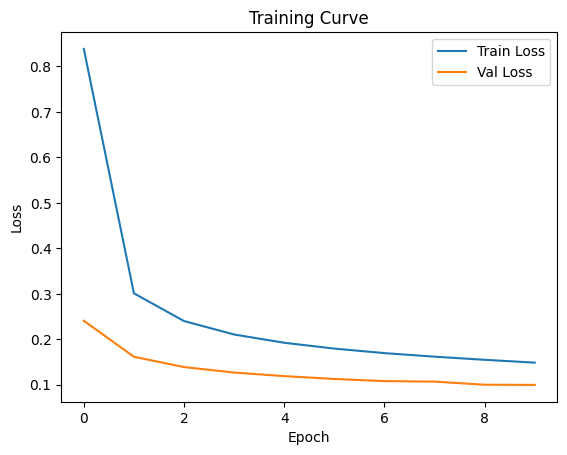

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()


In [2]:
test_df = pd.read_csv("Test.csv")
test_ds = ProteinDataset(test_df, tokenizer, max_len, is_test=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

model.eval()
all_preds, all_ids = [], []

with torch.no_grad():
    for x, ids in test_loader:
        x = x.to(device)
        out = model(x)
        _, pred = out.max(1)
        all_preds.extend(pred.cpu().numpy())
        all_ids.extend(ids)


NameError: name 'pd' is not defined

In [1]:
label_map = train_ds.label_map
inv_map = {v: k for k, v in label_map.items()}

submission = pd.DataFrame({
    'SEQUENCE_ID': all_ids,
    'LABEL': [inv_map[i] for i in all_preds]
})
submission.to_csv("submission.csv", index=False)
submission.head()


NameError: name 'train_ds' is not defined